In [1]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import h5py

Using TensorFlow backend.


In [2]:
# Paths
raw_data_path = "./SCUT-FBP5500_v2/train_test_files/All_labels.txt"
model_weights_path = "./model_weights.h5"

In [3]:
%%time
# Load Data
raw_data = np.loadtxt(raw_data_path, delimiter=" ", unpack=True, dtype=str)
X_names = raw_data[0]
Y = raw_data[1]
Y = Y.astype(float)

X = []
i = 0
for i,img_name in enumerate(X_names):
    img = cv2.imread("./SCUT-FBP5500_v2/Images/" + img_name)
    X.append(img)
    i += 1
    if i == 100000:
        break

X = np.array(X)
print(X.shape)

(5500, 350, 350, 3)
CPU times: user 7.73 s, sys: 1.43 s, total: 9.16 s
Wall time: 10.9 s


2937
score : 3.95


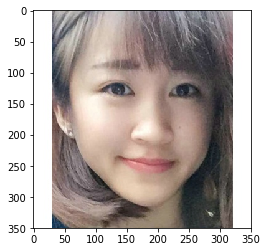

In [4]:
# Plot one image
ind = np.random.randint(len(X))
print(ind)
imgRGB = cv2.cvtColor(X[ind], cv2.COLOR_BGR2RGB)
print('score :', Y[ind])
plt.imshow(imgRGB)

In [5]:
%%time
# Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

CPU times: user 572 ms, sys: 1.28 s, total: 1.85 s
Wall time: 21.1 s


In [6]:
%%time
from keras.models import load_model

# Model initialisaition : resnet50 + denser layer with one cell (output) for regression
print('initializing model')
resnet = ResNet50(include_top=False, pooling="avg")
model = Sequential()
model.add(resnet)
model.add(Dense(1))

# We only train the last connections for now
model.layers[0].trainable = False

initializing model
Instructions for updating:
Colocations handled automatically by placer.
CPU times: user 19.5 s, sys: 1.64 s, total: 21.1 s
Wall time: 34.3 s


In [7]:
# On précise la formule de l'erreur et la technique d'optimisation
model.compile(loss='mean_squared_error', optimizer=Adam())

In [8]:
# Load existing weights (it can be put before or after the compilingmethode)
if os.path.isfile(model_weights_path):
    model.load_weights(model_weights_path)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [12]:
%%time
# Training of the last layer
model.fit(batch_size=32, x=X_train, y=y_train, epochs=1)
model.save_weights(model_weights_path)

Epoch 1/1
4400/4400 [==============================] - 2482s 564ms/step - loss: 0.1475
CPU times: user 2h 32min 11s, sys: 7min 58s, total: 2h 40min 10s
Wall time: 41min 22s


In [13]:
# Fit for all weights
model.fit(batch_size=10, x=X_train[:100], y=y_train[:100], epochs=1)

Epoch 1/1
100/100 [==============================] - 137s 1s/step - loss: 0.6219


In [13]:
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)

1100/1100 [==============================] - 773s 703ms/step
0.35489089261401785
